# Classification with TensorFlow Lite for ESP32-CAM
### Подготовил: Степанюк Денис Борисович

In [1]:
# Библиотека для работы с многомерными массивами и матрицами чисел.
import numpy as np
import PIL
import os

In [2]:
# Библиотека для визуализации данных.
import matplotlib.pyplot as plt

# Библиотека для визуализации данных, построенная на основе matplotlib.
import seaborn as sns

# Библиотека для создания и обучения моделей глубокого обучения.
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.callbacks import ReduceLROnPlateau

# Платформа для машинного обучения, разработанная Google, которая предоставляет инструменты для создания, 
# обучения и развертывания моделей машинного и глубокого обучения
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Библиотека для машинного обучения, которая предоставляет множество алгоритмов и инструментов для построения, 
#обучения и оценки моделей машинного обучения.
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

# Проверка доступных устройств

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

# Загрузка и аугментация данных

In [4]:
# Путь к папке с данными(фотографиями) для обучения.
DATASET_PATH = "C:/Users/Deniss/Desktop/ESP32-CAM/015_ESP32-CAM_Classification/Python_Classification/Dataset"

# Размеры изображения:
IMAGE_HEIGHT = 32
IMAGE_WIDTH = 32
CHANNELS = 3

# Список сущностей для классификации.
LABELS = os.listdir(DATASET_PATH)
# Кол-во сущностей для классификации.
NUM_of_LABELS = len(LABELS)
print(LABELS, " :: ", NUM_of_LABELS)

# Параметры генератора данных для проверки модели.
valid_datagen_kwargs = dict(rescale = (1. / 255), validation_split = .1)
# Параметры генератора данных для обучения модели.
train_datagen_kwargs = dict(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening = True,  # apply ZCA whitening
        rotation_range=180,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.15, # Randomly zoom image 
        width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
        rescale=1./255,
        validation_split = .1)

['Matrjona', 'Mouse', 'Spanner']  ::  3


### ImageDataGenerator 
Предназначен для преобразования изображений в реальном времени. Он помогает увеличить объем тренировочных данных за счёт "аугментации" (расширения) данных, что особенно полезно при обучении моделей глубокого обучения на небольших наборах данных. Этот метод улучшает обобщающую способность модели, делая её более устойчивой к вариациям в изображениях.

### Аугментация (от латинского augmentatio — "увеличение")
В контексте машинного обучения и компьютерного зрения — это процесс искусственного увеличения объема тренировочных данных за счет применения различных преобразований. В основном, аугментация применяется к изображениям, чтобы улучшить обобщающую способность модели, сделав её более устойчивой к различным вариациям.

In [5]:
# Инициализация генератора данных для проверки модели.
valid_datagen = ImageDataGenerator(**valid_datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
DATASET_PATH,
subset = "validation",
shuffle = True,
target_size = (IMAGE_HEIGHT, IMAGE_WIDTH)
)

# Инициализация генератора данных для обучения модели.
train_datagen = ImageDataGenerator(**train_datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
DATASET_PATH,
subset = "training",
shuffle = True,
target_size = (IMAGE_HEIGHT, IMAGE_WIDTH)
)

Found 124 images belonging to 3 classes.
Found 1123 images belonging to 3 classes.


C:\Users\Deniss\anaconda3\envs\ml_env\lib\site-packages\keras_preprocessing\image\image_data_generator.py:337: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


# Визуализация данных

C:\Users\Deniss\anaconda3\envs\ml_env\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Deniss\anaconda3\envs\ml_env\lib\site-packages\keras_preprocessing\image\image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Deniss\AppData\Local\Temp\ipykernel_19716\2713803056.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


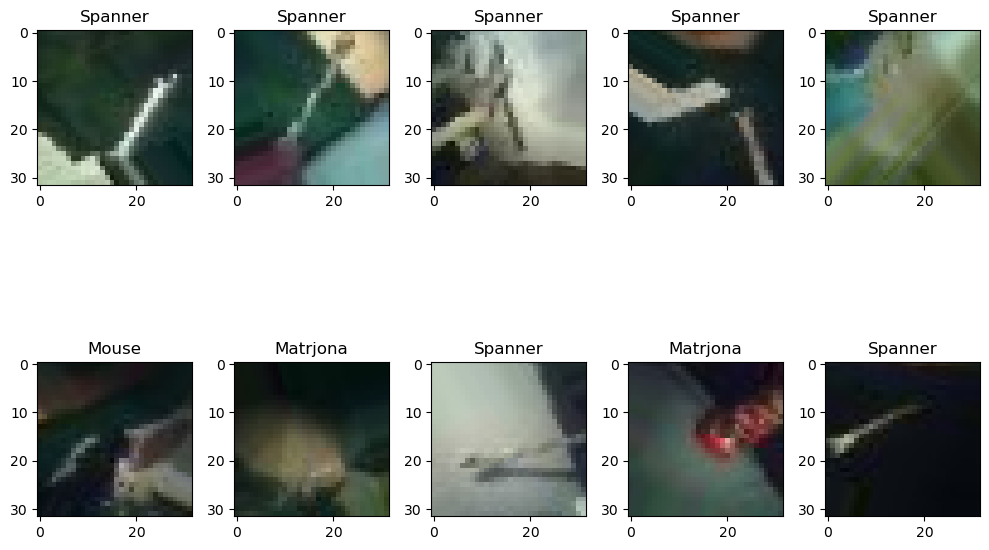

In [6]:
# Отобразим изображения из генератора данных для обучения модели.
f, ax = plt.subplots(2,5) 
f.set_size_inches(10, 10)

for image_batch, label_batch in train_generator:
    k = 0
    for i in range(2):
        for j in range(5):
            label = LABELS[np.argmax(label_batch[k,:])]
            image = image_batch[k,:,:,:]
            ax[i,j].imshow(image.reshape(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
            ax[i,j].set_title(label)
            k += 1
        plt.tight_layout()
    break

C:\Users\Deniss\AppData\Local\Temp\ipykernel_19716\2156468351.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


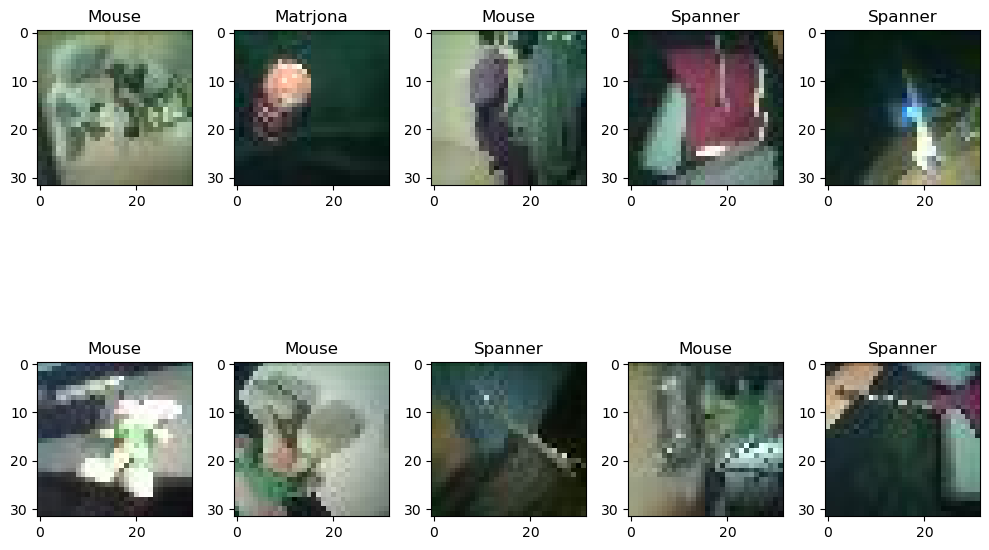

In [7]:
# Отобразим изображения из генератора данных для проверки модели.
f, ax = plt.subplots(2,5) 
f.set_size_inches(10, 10)

for image_batch, label_batch in valid_generator:
    k = 0
    for i in range(2):
        for j in range(5):
            label = LABELS[np.argmax(label_batch[k,:])]
            image = image_batch[k,:,:,:]
            ax[i,j].imshow(image.reshape(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
            ax[i,j].set_title(label)
            k += 1
        plt.tight_layout()
    break

In [8]:
# Выведим разные представления наименований сущностей для классификации.
for image_batch, label_batch in train_generator:
    for i in range(1):
        print("Labels: ", LABELS)
        
        binarized = label_batch[i]
        print("Binarized label: ", binarized)
        
        index = np.argmax(label_batch[i])
        print("Index of label: ", index)
        
        label = LABELS[index]
        print("Label: ", label)
    break

Labels:  ['Matrjona', 'Mouse', 'Spanner']
Binarized label:  [1. 0. 0.]
Index of label:  0
Label:  Matrjona


# СВЁРТОЧНЫЕ НЕЙРОННЫЕ СЕТИ
**Свёрточная нейронная сеть — это особый тип реализации искусственного интеллекта, который использует специальную математическую операцию, называемую свёрткой, для обработки данных из изображений.**

* **Свёртка выполняется путём перемножения двух матриц и получения третьей, меньшей матрицы.**
* **Сеть принимает входное изображение и использует фильтр (или ядро) для создания карты признаков, описывающей изображение.**
* **В операции свёртки фильтр (обычно матрица 2x2 или 3x3) скользит по матрице изображения. Соответствующие числа в обеих матрицах перемножаются и складываются, образуя одно число, описывающее данный участок изображения. Этот процесс повторяется для всего изображения. Принцип работы показан на следующей иллюстрации.**
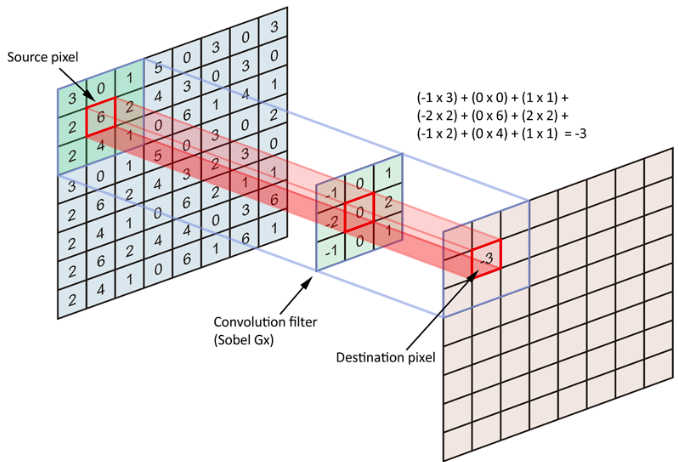

# Обучение модели

In [9]:
# Определим объект для динамической настройки скорости обучения (learning rate) во время тренировки модели.
    # monitor: параметр указывает, какую метрику следует отслеживать для принятия решения о снижении скорости обучения.
    # patience = 2: Если в течение двух эпох не будет улучшений, скорость обучения будет уменьшена.
    # verbose = 1: Если установлен в 1, то в консоль будут выводиться сообщения о снижении скорости обучения.
    # factor=0.25: Это коэффициент, на который будет умешаться текущая скорость обучения, если не наблюдается улучшения.
    # min_lr: Это минимально допустимое значение для скорости обучения.
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 8, verbose=1, factor=0.5, min_lr=0.000001)

In [10]:
# Инициализация модели.
model = Sequential()

# 1-й свёрточный слой (вход молели).
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS)))
# Слой максимального пулинга для 1-го свёрточного слоя.
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

# 2-й свёрточный слой.
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
# Отключить 20% случайных нейронов в слое во время обучения. 
model.add(Dropout(0.2))
# Слой максимального пулинга для 2-го свёрточного слоя.
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

# 3-й свёрточный слой.
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
# Отключить 20% случайных нейронов в слое во время обучения. 
model.add(Dropout(0.2))
# Слой максимального пулинга для 3-го свёрточного слоя.
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

# 4-й свёрточный слой.
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
# Отключить 20% случайных нейронов в слое во время обучения. 
model.add(Dropout(0.2))

# 5-й свёрточный слой.
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
# Cлой для преобразования многомерных данных в одномерный вектор. 
model.add(Flatten())

# 1-й полносвязный слой.
model.add(Dense(units = 256 , activation = 'relu'))
# Отключить 30% случайных нейронов в слое во время обучения. 
model.add(Dropout(0.3))

# 2-й полносвязный слой.
model.add(Dense(units = 64 , activation = 'relu'))
# Отключить 30% случайных нейронов в слое во время обучения. 
model.add(Dropout(0.3))

# 3-й полносвязный слой (выход модели).
model.add(Dense(units = NUM_of_LABELS , activation = 'softmax'))

# Собрать модель.
    # optimizer: оптимизатор, который будет использоваться для обновления весов модели во время обучения.
    # loss: функция потерь, которая будет использоваться для оценки качества предсказаний модели. 
    # metrics: метрика, которая будет отслеживаться во время обучения и валидации чтобы понять, насколько хорошо модель работает на данных.
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

# Вывод текстового представления структуры модели нейронной сети. 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 128)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 256)         295168    
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 256)         0

### Запустить обучение модели.

In [11]:
# Кол-во итераций обучения.
Epochs = 150

# Запустить обучение модели.
history = model.fit(train_generator, epochs = Epochs, validation_data = valid_generator, callbacks = [learning_rate_reduction])

# Сохранить модель.
model.save('model.h5')

Epoch 1/150
36/36 [==============================] - 2s 46ms/step - loss: 1.1039 - accuracy: 0.3250 - val_loss: 1.0986 - val_accuracy: 0.3306
Epoch 2/150
36/36 [==============================] - 2s 43ms/step - loss: 1.0991 - accuracy: 0.3241 - val_loss: 1.0985 - val_accuracy: 0.3306
Epoch 3/150
36/36 [==============================] - 2s 42ms/step - loss: 1.0992 - accuracy: 0.3313 - val_loss: 1.0980 - val_accuracy: 0.3387
Epoch 4/150
36/36 [==============================] - 1s 42ms/step - loss: 1.0994 - accuracy: 0.3348 - val_loss: 1.0976 - val_accuracy: 0.3871
Epoch 5/150
36/36 [==============================] - 1s 41ms/step - loss: 1.0996 - accuracy: 0.3241 - val_loss: 1.0976 - val_accuracy: 0.3548
Epoch 6/150
36/36 [==============================] - 1s 41ms/step - loss: 1.0931 - accuracy: 0.3633 - val_loss: 1.0988 - val_accuracy: 0.3387
Epoch 7/150
36/36 [==============================] - 1s 41ms/step - loss: 1.1001 - accuracy: 0.3384 - val_loss: 1.0982 - val_accuracy: 0.3387
Epoch 

In [12]:
print("Accuracy of the model is - " , model.evaluate(valid_generator)[1]*100 , "%")


4/4 [==============================] - 0s 8ms/step - loss: 0.3568 - accuracy: 0.8710
Accuracy of the model is -  87.09677457809448 %


# Анализ процесса обучения модели

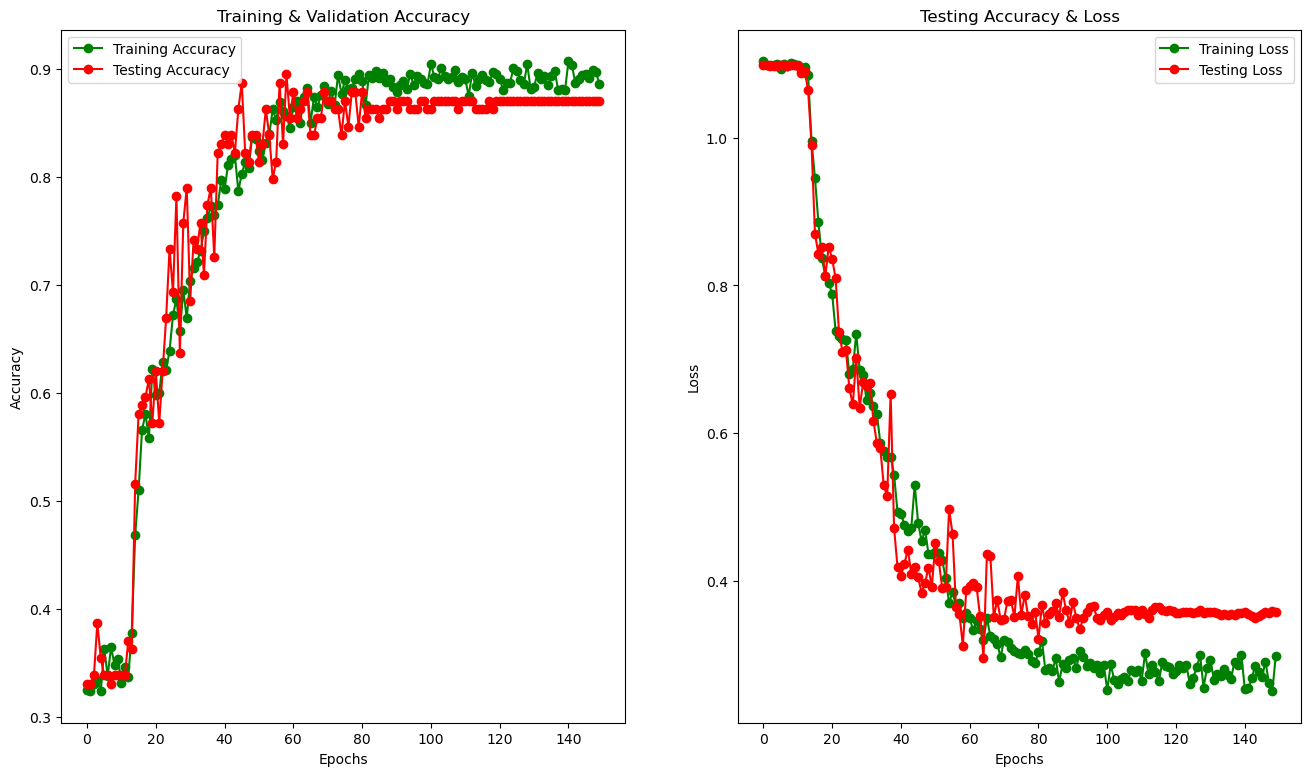

In [13]:
epochs = [i for i in range(Epochs)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

# Обзор предсказаний модели

##### Отобразим изображения из генератора данных для проверки модели и предсказания к ним.

C:\Users\Deniss\AppData\Local\Temp\ipykernel_19716\2597161850.py:16: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


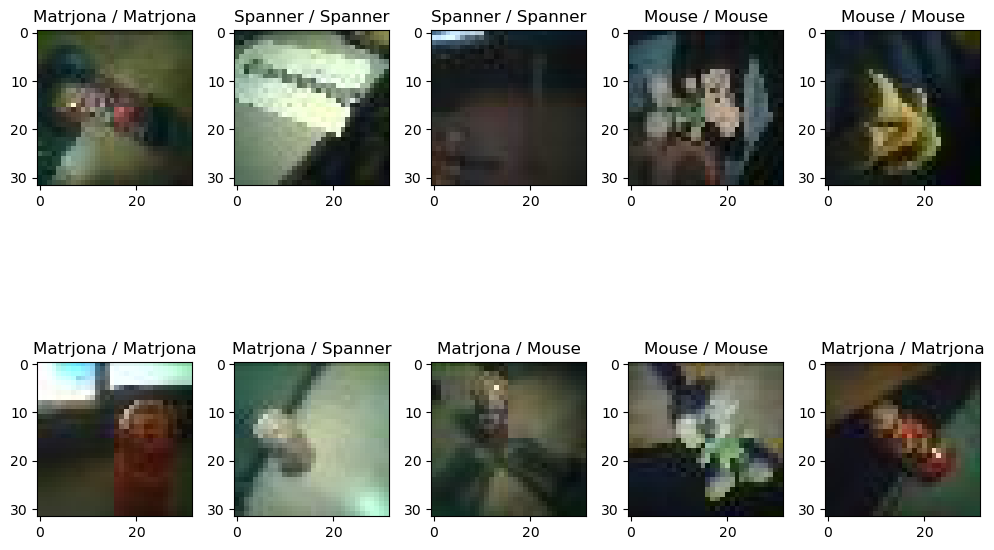

In [18]:
# Отобразим изображения из генератора данных для проверки модели и предсказания к ним.
f, ax = plt.subplots(2,5) 
f.set_size_inches(10, 10)

for image_batch, label_batch in valid_generator:
    preds = model.predict(image_batch)
    k = 0
    for i in range(2):
        for j in range(5):
            label_original = LABELS[np.argmax(label_batch[k,:])]
            label_predicted = LABELS[np.argmax(preds[k,:])]
            image = image_batch[k,:,:,:]
            ax[i,j].imshow(image.reshape(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
            ax[i,j].set_title(label_original + " / " + label_predicted)
            k += 1
        plt.tight_layout()
    break

In [23]:
# Выведим разные представления наименований сущностей для классификации и предсказания.
for image_batch, label_batch in train_generator:
    for i in range(1):
        print("Labels: ", LABELS)
        
        binarized = label_batch[i]
        print("Binarized label: ", binarized)

        prediction = model.predict(image_batch[i].reshape(1, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
        print("Prediction: ", prediction)
        
        index = np.argmax(label_batch[i])
        print("Index of label: ", index)

        index_of_prediction = np.argmax(prediction)
        print("Index of prediction: ", index_of_prediction)
        
        label = LABELS[index]
        print("Label: ", label)

        label_of_prediction = LABELS[index_of_prediction]
        print("Predicted label: ", label_of_prediction)
    break

Labels:  ['Matrjona', 'Mouse', 'Spanner']
Binarized label:  [0. 1. 0.]
Prediction:  [[0.352753   0.44496554 0.20228148]]
Index of label:  1
Index of prediction:  1
Label:  Mouse
Predicted label:  Mouse


# Конвертируем модель в облегчённый формат

##### https://notebook.community/jhseu/tensorflow/tensorflow/lite/g3doc/performance/post_training_integer_quant


### Подготавливаем репрезентативную выборку

In [24]:
# Массив изображений репрезентативной выборки.
image_numpy = []
# Массив наименований сущностей репрезентативной выборки.
label_numpy = []

stop = 0
for image_batch, label_batch in valid_generator:
    image_numpy.append(image_batch[:28,:,:,:])
    label_numpy.append(label_batch[:28,:])
    stop += 1
    if stop > 3:
        break

image_numpy = np.array(image_numpy)
image_numpy = image_numpy.reshape(-1, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS)

label_numpy = np.array(label_numpy)
label_numpy = label_numpy.reshape(-1, NUM_of_LABELS)

# Размер репрезентативной выборки.
REPRESENTATIVE_SIZE = label_numpy.shape[0]

In [25]:
def representative_dataset():
    for i in range(REPRESENTATIVE_SIZE):
        nxt = image_numpy[i].reshape(1, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS)
        yield([nxt])

### Конвертируем модель

In [26]:
# Передаём модель в конвертер.
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Передаём репрезентативную выборку в конвертер.
converter.representative_dataset = representative_dataset #representative_dataset_gen

# Указываем оптимизатор для модели.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Передаём набор встроенных операций, которые поддерживают 8-битные целочисленные (от -128 до 127) вычисления. 
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Указываем что вход модели отныне принимает 8-битный целочисленный тип данных (от -128 до 127).
converter.inference_input_type = tf.int8
# Указываем что выход модели отныне выдаёт 8-битный целочисленный тип данных (от -128 до 127).
converter.inference_output_type = tf.int8

tflite_model = converter.convert()

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\Deniss\AppData\Local\Temp\tmppl2kpq65\assets


In [27]:
# Сохранить облегчённую модель.
open("model.tflite", "wb").write(tflite_model)

1048800

##### Команда для текстового редактора "vim" чтобы преобразовать бинарный файл в C/C++ формат, который можно использовать как массив байтов в исходном коде для ESP32-CAM.

#### xxd -i model.tflite > model.cc

In [28]:
# Путь к сохранённой облегчённой модели.
tflite_model_path = "model.tflite"

# Загрузка модели и выделение памяти под тензоры.
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Получить входной и выходной тензоры.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Вывести размеры входного и выходного тензора.
input_shape = input_details[0]['shape']
output_shape = output_details[0]['shape']
print(input_shape)
print(output_shape)

[ 1 32 32  3]
[1 3]


In [29]:
# Изменить размерность входного и выходного тензоров.
interpreter.resize_tensor_input(input_details[0]['index'], (REPRESENTATIVE_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
interpreter.resize_tensor_input(output_details[0]['index'], (REPRESENTATIVE_SIZE, NUM_of_LABELS))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [112  32  32   3]
Input Type: <class 'numpy.int8'>
Output Shape: [112   3]
Output Type: <class 'numpy.int8'>


In [30]:
# Поменять тип данных изображений репрезентативной выборки с float (от 0.0 до 1.0) на 8-битный целочисленный тип данных (от -128 до 127).
test_imgs_numpy = np.array(((image_numpy * 2) - 1.0) * 127.5, dtype=np.int8)

from time import time
t1 = time()
interpreter.set_tensor(input_details[0]['index'], test_imgs_numpy)
interpreter.invoke()
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print((time()-t1)/REPRESENTATIVE_SIZE)
print("Prediction results shape:", tflite_model_predictions.shape)

print("Prediction:", tflite_model_predictions[5,:])
prediction_classes = np.argmax(tflite_model_predictions, axis=1)

0.15544806207929338
Prediction results shape: (112, 3)
Prediction: [ 126 -128 -127]


In [31]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(prediction_classes, np.argmax(label_numpy,axis=1))

for i in range(3):
    print(tflite_model_predictions[i], " ::  ",  label_numpy[i])

print('Test accuracy TFLITE model :', acc)

[ 127 -128 -128]  ::   [1. 0. 0.]
[-121  115 -122]  ::   [1. 0. 0.]
[-128 -126  125]  ::   [0. 0. 1.]
Test accuracy TFLITE model : 0.8928571428571429
